In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
import cartopy.crs as ccrs
import yaml
import os
import xorca_brokenline as bl
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator
from xhistogram.xarray import histogram as xhist
import dask
import dask.distributed
import dask_jobqueue
import matplotlib.dates as mdates
import seawater as sw
import warnings

warnings.filterwarnings("ignore")

In [2]:
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4,
    memory="16GB",
    processes=1,  # Dask workers per job
    # SLURM job script things
    queue="base",
    walltime="04:00:00",
    # Dask worker network and temporary storage
    interface="ib0",
    local_directory="$TMPDIR",  # for spilling tmp data to disk
    log_directory="slurm/",
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15)  # 15
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.22:34885/status,
Dashboard: http://172.18.4.22:34885/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.22:32775,Workers: 0
Dashboard: http://172.18.4.22:34885/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Figure 7

In [3]:
## NAO

df = pd.read_table(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/norm.nao.monthly.b5001.current.ascii",
    header=None,
    delimiter="   ",
    names=["year", "month", "NAO"],
)

NAO = df["NAO"]

NAO_xr = (
    xr.DataArray(
        data=[NAO],  # Pass a list of your NumPy arrays
        dims=["variable", "time_counter"],  # Adjust dimensions accordingly
        coords={
            "time_counter": pd.date_range(
                start="1950-01-01", end="2025-05-31", freq="M"
            )
        },  # Add coordinates if available
        name="NAO",  # Name your data array
    )
    .isel(variable=0)
    .sel(time_counter=slice("1990", "2025-05"))
)


def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time_counter)
    month_length = ds.time_counter.dt.days_in_month

    # Calculate the weights by grouping by 'time_counter.season'
    weights = (
        month_length.groupby("time_counter.season")
        / month_length.groupby("time_counter.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(
        weights.groupby("time_counter.season").sum().values, np.ones(4)
    )

    # Calculate the weighted average
    return (ds * weights).groupby("time_counter.season").sum(dim="time_counter")


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return fit, da - fit


S_trspt = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/S_trspt_1.nc"
).S_trspt
S_trspt_seasonlity_remove = S_trspt.groupby("time_counter.month") - S_trspt.groupby(
    "time_counter.month"
).mean(dim="time_counter")
S_trspt_seasonlity_remove_detrend = detrend_dim(
    S_trspt_seasonlity_remove, "time_counter"
)[1]
rolling_mean_NAO = (
    NAO_xr.rolling(time_counter=12, center=True)
    .mean()
    .sel(time_counter=slice("1993", "2020"))
)

V_trspt = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/V_trspt.nc"
).trsp
V_trspt_seasonality_remove = V_trspt.groupby("time_counter.month") - V_trspt.groupby(
    "time_counter.month"
).mean(dim="time_counter")
V_trspt_seasonality_remove_detrend = detrend_dim(
    V_trspt_seasonality_remove, "time_counter"
)[1]


S_trspt_detrend = detrend_dim(
    S_trspt_seasonlity_remove.rolling(time_counter=12, center=True).mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019"))
V_trspt_detrend = detrend_dim(
    V_trspt_seasonality_remove.rolling(time_counter=12, center=True).mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019"))

In [4]:
FBC_overflow_trspt = pd.read_csv(
    "/gxfs_work/geomar/smomw452/GLORYS12/Data/observations/FBC_overflow_transport.txt",
    delim_whitespace=True,
)


# Function to convert decimal year to datetime
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    fractional_year = decimal_year - year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    # Approximate days in year (assuming non-leap year for simplicity)
    days_in_year = 365
    days_passed = int(fractional_year * days_in_year)
    return start_of_year + pd.Timedelta(days=days_passed)


# Apply function to DataFrame
FBC_overflow_trspt["Date"] = FBC_overflow_trspt["Year"].apply(decimal_year_to_datetime)

FBC_overflow_trspt["Date"] = pd.to_datetime(FBC_overflow_trspt["Date"])

FBC_overflow_trspt.set_index("Date", inplace=True)
FBC_overflow_trspt_monthly_means = FBC_overflow_trspt["Flux"].resample("M").mean()

FBC_trspt_obs_xr = FBC_overflow_trspt_monthly_means.to_xarray().rename(
    {"Date": "time_counter"}
)
FBC_trspt_obs_seasonality_remove = FBC_trspt_obs_xr.groupby(
    "time_counter.month"
) - FBC_trspt_obs_xr.groupby("time_counter.month").mean(dim="time_counter")
FBC_obs_trspt_detrend = detrend_dim(
    FBC_trspt_obs_xr.groupby("time_counter.month")
    - FBC_trspt_obs_xr.groupby("time_counter.month").mean(dim="time_counter"),
    "time_counter",
)[1]

model = S_trspt_detrend.sel(time_counter=slice("1996", "2019"))
obs = detrend_dim(
    FBC_obs_trspt_detrend.rolling(time_counter=12, center=True).mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019"))

In [5]:
def filter_beached_particles(ds, dim=None):
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(
        particles_beached.load(), drop=True
    )

    return ds_particles_reach_zero_salinity_beached


def compute_density(ds):
    ds_density = (
        xr.apply_ufunc(
            sw.eos80.pden,
            ds.salt,
            ds.temp,
            0,
            dask="parallelized",
            output_dtypes=[np.float64],
        )
        - 1000
    )
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens


def calc_min_max(ds):
    lon_min = float(ds.lon.min().values)
    lon_max = float(ds.lon.max().values)
    lat_min = float(ds.lat.min().values)
    lat_max = float(ds.lat.max().values)
    res = {
        "lon_min": lon_min,
        "lon_max": lon_max,
        "lat_min": lat_min,
        "lat_max": lat_max,
    }
    return res


def filter_particles_by_density(ds, density_threshold, dim=None):
    # Identify particles with density less than the threshold
    particles_less_than_threshold = (ds.sigma0 < density_threshold).any(dim)

    # Identify particles that reach or exceed the threshold
    particles_that_reach_threshold = ~particles_less_than_threshold

    # Filter the dataset to include only particles that exceed the threshold
    ds_particles_greater_than_threshold = ds.where(
        particles_that_reach_threshold.compute(), drop=True
    )

    return ds_particles_greater_than_threshold


hours_to_days = 0.0416667
hours_to_months = 0.00136986
hours_to_years = 0.000114155
time_conversion = hours_to_days
velocity_conversion = (
    1852 * 60
)  # multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)


# ds_orig = xr.open_dataset('../data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')

ds_orig = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/data/level2/corrected_1995_2020_parcels_releases_seed-2345.zarr",
    engine="zarr",
    chunks="auto",
)


ds_orig = filter_beached_particles(ds_orig, "obs")
ds_orig = compute_density(ds_orig)

ds_overflows = filter_particles_by_density(ds_orig, 27.8, "obs")

ds_overflows = ds_overflows.where(ds_overflows.age * hours_to_years > -10, drop=False)

In [6]:
p = ds_overflows
p["start_time"] = p.isel(obs=0).time
p = p.set_coords("start_time")
p = p.set_xindex("start_time")


outdir = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/data/level3/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f"{outdir}/minmax.yaml"):
    with open(f"{outdir}/minmax.yaml", "r") as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds_overflows)
    with open(f"{outdir}/minmax.yaml", "w") as file:
        yaml.dump(results, file)

n = 0.25  # .25
lon_bins = np.arange(results["lon_min"], results["lon_max"], n)
lat_bins = np.arange(results["lat_min"], results["lat_max"], n)


def rechunk_for_hist(var):
    return var.chunk({"trajectory": 50, "obs": -1})


def rechunk_lat_lon(ds):
    lon_rechunk = rechunk_for_hist(ds["lon"])
    lat_rechunk = rechunk_for_hist(ds["lat"])

    return lon_rechunk, lat_rechunk


# converting the age from nano seconds

hours_to_days = 0.0416667
hours_to_months = 0.00136986
hours_to_years = 0.000114155
time_conversion = hours_to_days
velocity_conversion = (
    1852 * 60
)  # multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)

# converting the age from nano seconds
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/Data/"
hours_to_days = 0.0416667
hours_to_months = 0.00136986
hours_to_years = 0.000114155
time_conversion = hours_to_days
velocity_conversion = (
    1852 * 60
)  # multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)

mesh_mask = xr.open_dataset(inpath + "mesh_masks/mesh_mask.nc")
mesh_hzgr = xr.open_dataset(inpath + "mesh_masks/mesh_hzgr.nc")
mesh_hgr = xr.open_dataset(inpath + "mesh_masks/mesh_hgr.nc")

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point
bathymetry = (
    (z * t_mask)
    .isel(t=0)
    .sum(dim="z")
    .assign_coords({"nav_lat": mesh_hgr.nav_lat, "nav_lon": mesh_hgr.nav_lon})
)

# turn zeros into nans, easier to see where continents are
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask != 0).isel(t=0, z=0)

In [36]:
def compute_probability_perc(traj_line_not_all):
    # Create a 2D histogram of the latitude and longitude
    heat_map_time_non = xhist(
        traj_line_not_all.lat,
        traj_line_not_all.lon,
        bins=[lat_bins, lon_bins],
        dim=["obs"],
        bin_dim_suffix="",
    )

    heat_map_time_unique_non = (heat_map_time_non > 0).sum(dim="trajectory")

    heat_map_percentage_non = (
        heat_map_time_unique_non / traj_line_not_all.trajectory.size
    ) * 100

    heat_map_percentage_non_cp = heat_map_percentage_non.compute()

    return heat_map_percentage_non_cp


lon_rechunk, lat_rechunk = (
    rechunk_lat_lon(ds_overflows)[0],
    rechunk_lat_lon(ds_overflows)[1],
)

grouped_data = p.groupby("start_time")
grouped_datasets = {start_time: group for start_time, group in grouped_data}
grouped_values = list(grouped_datasets.values())

start_year = 1995  # 2003
end_year = 2020

# Create a dictionary to store concatenated data for each year
annual_data = {}

# Loop through each year and select the corresponding indices
for year in range(start_year, end_year + 1):
    # Define the start and end dates for the current year
    start_date = pd.Timestamp(f"{year}-01-01")
    end_date = pd.Timestamp(f"{year}-12-31")

    # Create a date range with 5-day frequency for the current year
    date_range = pd.date_range(start=start_date, end=end_date, freq="5D")

    # Calculate the start and end indices based on the date range
    start_index = (start_date - pd.Timestamp("1995-01-01")).days // 5  # '2003-01-01'
    end_index = (
        end_date - pd.Timestamp("1995-01-01")
    ).days // 5 + 1  # +1 to include the end date

    # Select the data for the current year
    selected_values = grouped_values[start_index:end_index]

    # Concatenate the selected values along the 'trajectory' dimension
    concatenated_data = xr.concat(selected_values, dim="trajectory")

    # Store the concatenated data in the dictionary
    annual_data[year] = concatenated_data

ValueError: must supply at least one object to concatenate

In [8]:
# high trspt years

release_2003 = annual_data.get(2003)
release_1997 = annual_data.get(1997)
release_2011 = annual_data.get(2011)

# low trspt years
release_2012 = annual_data.get(2012)
release_1999 = annual_data.get(1999)
release_2015 = annual_data.get(2015)

In [9]:
high_trspt_trajs = xr.concat(
    [release_1997, release_2003, release_2011], dim="trajectory"
)

Svinoy_high_trspt_trjs = (
    (high_trspt_trajs.lon < 5.5)
    & (high_trspt_trajs.lat > 62.24)
    & (high_trspt_trajs.lon > -1)
    & (high_trspt_trajs.lat < 65)
)

N_section_high_trspt_trjs = (
    (high_trspt_trajs.lon > -6.0833 - 5)
    & (high_trspt_trajs.lat > 62.3333)
    & (high_trspt_trajs.lon < -6.0833 + 5)
    & (high_trspt_trajs.lat < 64.5)
)

Svinoy_box = high_trspt_trajs.where(Svinoy_high_trspt_trjs, drop=False)
N_box = high_trspt_trajs.where(N_section_high_trspt_trjs, drop=False)

In [10]:
# get amount of particles crossing only N, only Svinoy, and then N and Svinoy


def get_unique_crossings(ds_line_cross):
    unique_crossings = (ds_line_cross.any(dim="obs")).sum(dim="trajectory").compute()
    return unique_crossings.values


def check_overlap(section1, section2):
    # Check if particles cross both sections
    cross_section1 = section1.any(dim="obs")
    cross_section2 = section2.any(dim="obs")

    # Calculate overlap (particles that cross both sections)
    overlap_crossings = (cross_section1 & cross_section2).sum(dim="trajectory")

    overlap_crossings_cp = overlap_crossings.compute()
    return overlap_crossings_cp.values
    # print('Overlap crossings =', overlap_crossings_cp.values)


def calculate_slope_intercept(x1, y1, x2, y2):
    """Calculate the slope (m) and y-intercept (b) of a line."""
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b


def process_section(key, ds_orig):
    """Process the specified section and return datasets based on the key."""

    dist = 0.4  # Distance used for calculations

    if key == "Svinoy":
        box = Svinoy_box  # Use the Svinoy box
        m, b = calculate_slope_intercept(5.5, 62.24 - dist, -1, 65 - dist)
        m2, b2 = calculate_slope_intercept(5.5, 62.24 + dist, -1, 65 + dist)

        ds_window = box.lat >= box.lon * m + b
        ds_window2 = box.lat <= box.lon * m2 + b2
        ds_line_cross = (box.lat >= box.lon * m + b) & (box.lat <= box.lon * m2 + b2)

    elif key == "EIC":
        box = EIC_box  # Use the EIC box
        m, b = calculate_slope_intercept(-15, 66.25 - dist, -11.95, 68.7 - dist)
        m2, b2 = calculate_slope_intercept(-15, 66.25 + dist, -11.95, 68.7 + dist)

        ds_window = box.lat >= box.lon * m + b
        ds_window2 = box.lat <= box.lon * m2 + b2
        ds_line_cross = (box.lat >= box.lon * m + b) & (box.lat <= box.lon * m2 + b2)

    elif key == "N":
        box = N_box  # Use the N box
        ds_window = (box.lon <= -6.0833 + 0.1).astype(int)
        ds_window2 = (box.lon >= -6.0833 - 0.1).astype(int)
        ds_line_cross = (box.lon <= -6.0833 + 0.1) & (box.lon >= -6.0833 - 0.1).astype(
            int
        )

    else:
        raise ValueError("Invalid key provided. Please use 'Svinoy', 'EIC', or 'N'.")

    # Convert boolean arrays to integers
    ds_window = ds_window.astype(int)
    ds_window2 = ds_window2.astype(int)
    ds_line_cross = ds_line_cross.astype(int)

    # Create datasets based on the conditions
    ds_line = ds_orig.where(ds_window & ds_window2, drop=False)

    return {"ds_line": ds_line, "line_cross": ds_line_cross}


def process_ocean_basins(bathy):
    """Process bathymetric data based on specified conditions."""

    # Define the conditions for the first region (e.g., lofoten)
    # m, b = calculate_slope_intercept(-4.5,70.7,2,68.4)
    # m3, b3 = calculate_slope_intercept(9,68.4,14,69.6)
    # m4, b4 = calculate_slope_intercept(6,72.5,-4.5,70.7)
    # m5,b5 = calculate_slope_intercept(14,69.6,6,72.5)

    m, b = calculate_slope_intercept(-4.5, 70.7, 2, 68.6)
    m3, b3 = calculate_slope_intercept(9, 68.6, 14, 69.6)
    m4, b4 = calculate_slope_intercept(6, 72.5, -4.5, 70.7)
    m5, b5 = calculate_slope_intercept(14, 69.6, 6, 72.5)

    ds_window = bathy.lat >= bathy.lon * m + b
    ds_window2 = bathy.lat >= 68.6
    ds_window3 = bathy.lat >= bathy.lon * m3 + b3
    ds_window4 = bathy.lat <= bathy.lon * m4 + b4
    ds_window5 = bathy.lat <= bathy.lon * m5 + b5

    lofoten = (ds_window & ds_window2 & ds_window3 & ds_window4 & ds_window5).astype(
        int
    )
    lofoten = xr.where(lofoten > 0, 1, 0).astype(int)
    lofoten = bathy.where(lofoten, drop=False)

    # Define the conditions for the second region (e.g., gsea)
    m, b = calculate_slope_intercept(-12, 74.5, -2.5, 76.7)
    m2, b2 = calculate_slope_intercept(-2.5, 76.7, 4, 74)
    m3, b3 = calculate_slope_intercept(4, 74, -1, 73)

    ds_window = bathy.lat <= bathy.lon * m + b
    ds_window2 = bathy.lat <= bathy.lon * m2 + b2
    ds_window3 = bathy.lat >= bathy.lon * m3 + b3
    ds_window4 = bathy.lat >= 73
    ds_window5 = bathy.lon >= -12
    gsea = (ds_window & ds_window2 & ds_window3 & ds_window4 & ds_window5).astype(int)
    gsea = xr.where(gsea > 0, 1, 0).astype(int)
    gsea = bathy.where(gsea, drop=False)

    # Define the conditions for the third region (e.g., isea)
    # m2, b2 = calculate_slope_intercept(-12.5, 66.5,-14, 67.5)
    # ds_window = bathy.lat >= 66.5
    # ds_window2 = bathy.lat >= bathy.lon * m2 + b2
    # ds_window3 = bathy.lon <= -8.75
    # ds_window4 = bathy.lat <= 70.2
    # ds_window5 = bathy.lon >= -14
    # isea = (ds_window & ds_window2 & ds_window5 & ds_window3 & ds_window4).astype(int) # & ds_window2 & ds_window3 & ds_window4
    # isea = xr.where(isea > 0, 1, 0).astype(int)
    # isea = bathy.where(isea, drop=False)
    isea_box = (
        (bathy.lon > -13.5) & (bathy.lat > 67.5) & (bathy.lon < -9.2) & (bathy.lat < 70)
    )  # lon > -14
    isea = bathy.where(isea_box, drop=False)

    # Define the conditions for the norwegian basin region
    m2, b2 = calculate_slope_intercept(-3, 69.5, 1, 67.5)

    ds_window = bathy.lon >= -6.2
    ds_window2 = bathy.lat >= 64
    ds_window3 = bathy.lon <= 1
    ds_window4 = bathy.lat <= 69.5
    ds_window5 = bathy.lat <= bathy.lon * m2 + b2

    nbasin = (ds_window & ds_window2 & ds_window3 & ds_window4 & ds_window5).astype(int)
    nbasin = xr.where(nbasin > 0, 1, 0).astype(int)
    nbasin = bathy.where(nbasin, drop=False)

    return {"lofoten": lofoten, "greenland": gsea, "iceland": isea, "norwegian": nbasin}


def filter_trajectories(ds_line, ds_all_trajs):
    """
    Filters trajectories based on whether they cross the line.

    Parameters:
    ds_orig (xarray.Dataset): The original dataset containing trajectory data.
    ds_line (xarray.Dataset): The dataset containing the line information.

    Returns:
    traj_not_line (xarray.Dataset): Trajectories that do not cross the line.
    traj_line (xarray.Dataset): Trajectories that cross the line.
    traj_all (xarray.Dataset): All trajectories from the original dataset.
    """
    # Count the number of NaN values in the 'temp' variable across the 'obs' dimension
    nans_per_traj = (ds_line["temp"].isnull()).sum(dim="obs").compute()

    # Select trajectories based on the NaN count
    traj_not_line = ds_all_trajs.sel(
        trajectory=(nans_per_traj == ds_line.obs.size)
    )  # select all trajs with all nans, i.e. not crossing
    traj_line = ds_all_trajs.sel(
        trajectory=(nans_per_traj != ds_line.obs.size)
    )  # select all trajs with at least one non-nan, i.e. crossing

    # Return all trajectories
    traj_all = ds_all_trajs

    return {
        "traj_line": traj_line,
        "traj_not_line": traj_not_line,
        "traj_all": traj_all,
    }

In [12]:
ds_Svinoy = process_section("Svinoy", high_trspt_trajs)["ds_line"]
ds_N = process_section("N", high_trspt_trajs)["ds_line"]


Svinoy_line_cross = filter_trajectories(ds_Svinoy, high_trspt_trajs)
N_line_cross = filter_trajectories(ds_N, high_trspt_trajs)

Svinoy_trajectories = set(Svinoy_line_cross["traj_line"]["trajectory"].values)
N_trajectories = set(N_line_cross["traj_line"]["trajectory"].values)
high_trspt_trajectories = set(high_trspt_trajs["trajectory"].values)

filtered_svinoy_trajectories = [
    traj for traj in Svinoy_trajectories if traj not in N_trajectories
]
filtered_N_trajectories = [
    traj for traj in N_trajectories if traj not in Svinoy_trajectories
]  #  and traj not in EIC_trajectories

intersecting_svinoy_only_overflows = sorted(
    set(filtered_svinoy_trajectories).intersection(high_trspt_trajectories)
)
intersection_N_only_overflows = sorted(
    set(filtered_N_trajectories).intersection(high_trspt_trajectories)
)
intersecting_N_Svinoy_overflows = sorted(
    set(Svinoy_trajectories)
    .intersection(N_trajectories)
    .intersection(high_trspt_trajectories)
)

overflows_crossing_only_Svinoy = ds_Svinoy.sel(
    trajectory=intersecting_svinoy_only_overflows
)
overflows_crossing_only_N = ds_N.sel(trajectory=intersection_N_only_overflows)
overflows_crossing_N_Svinoy = high_trspt_trajs.sel(
    trajectory=intersecting_N_Svinoy_overflows
)

# print(
#     "high transport years overshoot =",
#     100
#     * overflows_crossing_N_Svinoy.trajectory.size
#     / high_trspt_trajs.trajectory.size,
# )
# print(
#     "high transport years N =",
#     100 * overflows_crossing_only_N.trajectory.size / high_trspt_trajs.trajectory.size,
# )
# print(
#     "high transport years Svinoy =",
#     100
#     * overflows_crossing_only_Svinoy.trajectory.size
#     / high_trspt_trajs.trajectory.size,
# )

In [13]:
def compute_probability_weighted(traj_line_not_all):
    """
    Compute a heatmap where each bin counts how many particle positions occurred there,
    rather than only counting unique trajectories. This highlights regions where particles
    pass even if spread over a wide area.
    """
    # 2D histogram over lat/lon; sum over 'obs' (all recorded positions)
    heat_map_counts = xhist(
        traj_line_not_all.lat,
        traj_line_not_all.lon,
        bins=[lat_bins, lon_bins],
        dim=["obs"],
        bin_dim_suffix="",
    )

    # sum over trajectories to get total positions per bin
    heat_map_total = heat_map_counts.sum(dim="trajectory").compute()

    # normalize to fraction of all positions
    heat_map_prob = heat_map_total / heat_map_total.sum()

    return heat_map_prob

In [14]:
# high trspt years

release_2003 = annual_data.get(2003)
release_1997 = annual_data.get(1997)
release_2009 = annual_data.get(2009)  # 2011

# low trspt years
release_2012 = annual_data.get(2012)
release_1999 = annual_data.get(1999)
release_2015 = annual_data.get(2015)

# high trspt years
maps_2003 = compute_probability_perc(annual_data.get(2003))
maps_1997 = compute_probability_perc(annual_data.get(1997))
maps_2009 = compute_probability_perc(annual_data.get(2009))

maps_2003_weighted = compute_probability_weighted(annual_data.get(2003))
maps_1997_weighted = compute_probability_weighted(annual_data.get(1997))
maps_2009_weighted = compute_probability_weighted(annual_data.get(2009))

In [15]:
# low trspt years


maps_2012 = compute_probability_perc(annual_data.get(2012))
maps_1999 = compute_probability_perc(annual_data.get(1999))
maps_2015 = compute_probability_perc(annual_data.get(2015))

maps_2012_weighted = compute_probability_weighted(annual_data.get(2012))
maps_1999_weighted = compute_probability_weighted(annual_data.get(1999))
maps_2015_weighted = compute_probability_weighted(annual_data.get(2015))

# all overflows

hmap_weighed = compute_probability_weighted(p)
hmap = compute_probability_perc(p)

In [16]:
def get_mean_maps(ds, lon_rechunk, lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(
        lon_rechunk,
        lat_rechunk,
        bins=[lon_bins, lat_bins],
        weights=ds,
        dim=["obs", "trajectory"],
    )
    counts = xhist(
        lon_rechunk,
        lat_rechunk,
        bins=[lon_bins, lat_bins],
        weights=weights,
        dim=["obs", "trajectory"],
    )
    mean_temp = weighted_sum / counts
    return mean_temp


mean_high_transport = (maps_2003 + maps_2009 + maps_1997) / 3

mean_low_transport = (maps_2012 + maps_1999 + maps_2015) / 3

In [17]:
mean_high_transport_weighted = (
    maps_2003_weighted + maps_2009_weighted + maps_1997_weighted
) / 3
mean_low_transport_weighted = (
    maps_2012_weighted + maps_1999_weighted + maps_2015_weighted
) / 3
msk = xr.where(mean_high_transport > 0.01, 1, 0).rename(
    {"lat": "lat_bin", "lon": "lon_bin"}
)

In [18]:
contour_interval = 700

contour_levels = np.arange(
    np.floor(bathymetry.min() / contour_interval) * contour_interval,
    np.ceil(bathymetry.max() / contour_interval) * contour_interval,
    contour_interval,
)

lon, lat = maps_2003.lon, maps_2003.lat

In [19]:
# High transport

mean_vvel_2003 = get_mean_maps(
    annual_data.get(2003).vvel,
    rechunk_lat_lon(annual_data.get(2003))[0],
    rechunk_lat_lon(annual_data.get(2003))[1],
).compute()
mean_vvel_1997 = get_mean_maps(
    annual_data.get(1997).vvel,
    rechunk_lat_lon(annual_data.get(1997))[0],
    rechunk_lat_lon(annual_data.get(1997))[1],
).compute()
mean_vvel_2011 = get_mean_maps(
    annual_data.get(2011).vvel,
    rechunk_lat_lon(annual_data.get(2011))[0],
    rechunk_lat_lon(annual_data.get(2011))[1],
).compute()

## low transport

mean_vvel_2012 = get_mean_maps(
    annual_data.get(2012).vvel,
    rechunk_lat_lon(annual_data.get(2012))[0],
    rechunk_lat_lon(annual_data.get(2012))[1],
).compute()
mean_vvel_1999 = get_mean_maps(
    annual_data.get(1999).vvel,
    rechunk_lat_lon(annual_data.get(1999))[0],
    rechunk_lat_lon(annual_data.get(1999))[1],
).compute()
mean_vvel_2015 = get_mean_maps(
    annual_data.get(2015).vvel,
    rechunk_lat_lon(annual_data.get(2015))[0],
    rechunk_lat_lon(annual_data.get(2015))[1],
).compute()

mean_vvel_high_trspt_maps = (
    (mean_vvel_2003 + mean_vvel_1997 + mean_vvel_2011) / 3
).T * 1e5
mean_vvel_low_trspt_maps = (
    (mean_vvel_2012 + mean_vvel_1999 + mean_vvel_2015) / 3
).T * 1e5

In [20]:
plt.rcParams.update({"font.size": 15})

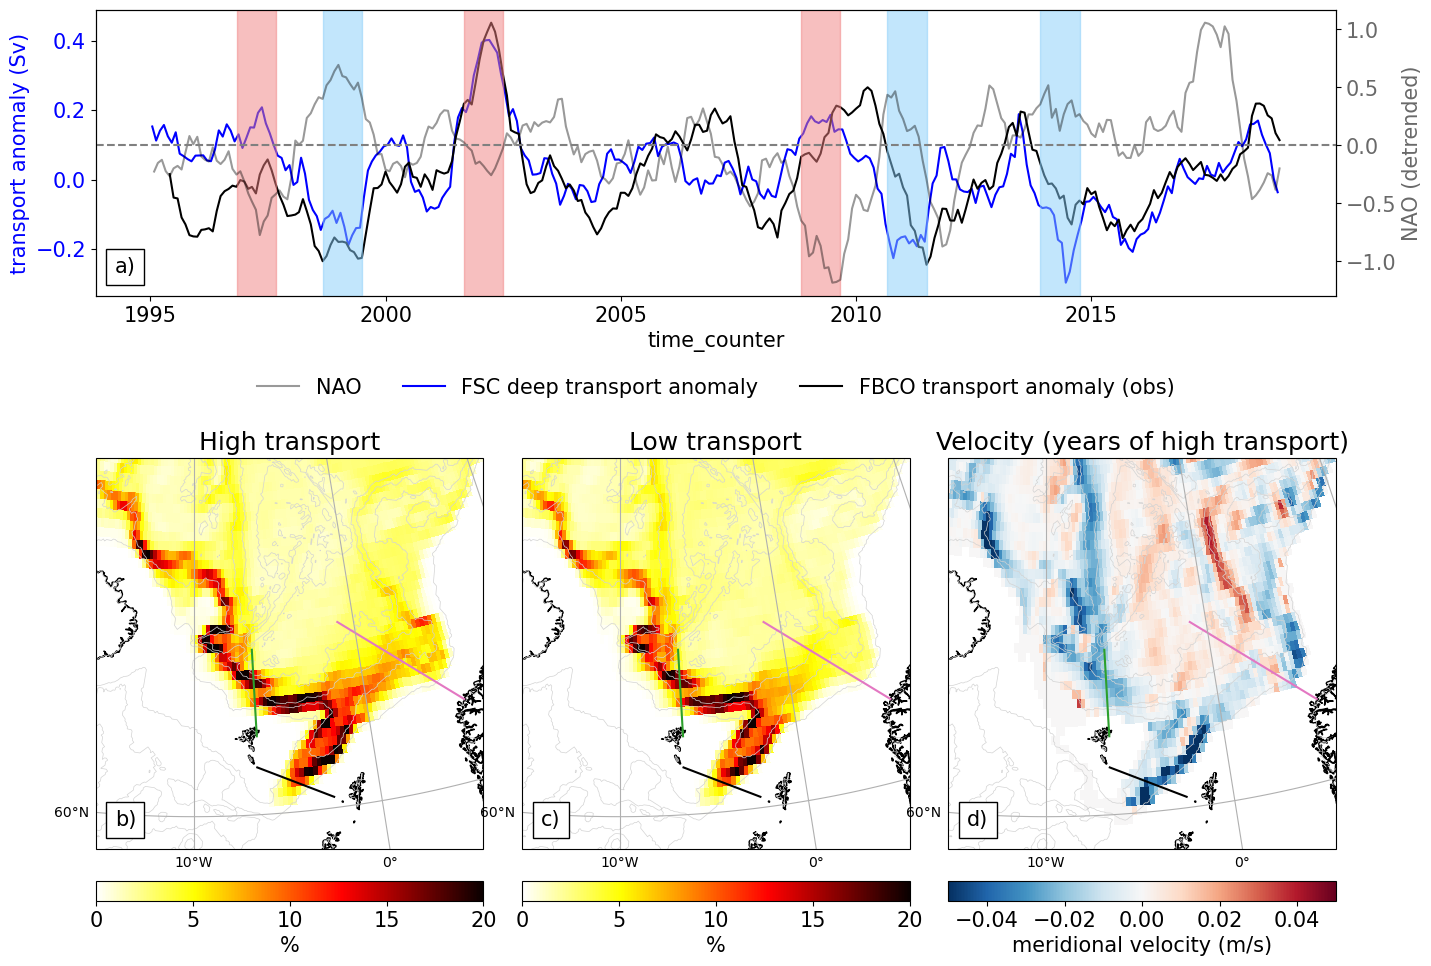

In [55]:
fig = plt.figure(figsize=(16, 13))  # Wider to accommodate 3 maps
gs = gridspec.GridSpec(
    nrows=2, ncols=3, height_ratios=[0.6, 1.5], hspace=0.0, wspace=0.1
)

# ---- TOP PANEL: TIME SERIES ----
ax1 = fig.add_subplot(gs[0, :])
S_trspt_detrend.sel(time_counter=slice("1996", "2019")).plot(
    ax=ax1, color="blue", label="FSC deep transport anomaly"
)
detrend_dim(
    FBC_obs_trspt_detrend.rolling(time_counter=12, center=True).mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019")).plot(
    ax=ax1, color="k", label="FBCO transport anomaly (obs)"
)
ax1.set_ylabel("transport anomaly (Sv)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
detrend_dim(rolling_mean_NAO, dim="time_counter")[1].sel(
    time_counter=slice("1996", "2019")
).plot(ax=ax2, color="k", alpha=0.4, label="NAO")
ax2.set_ylabel("NAO (detrended)", color="dimgrey")
ax2.tick_params(axis="y", labelcolor="dimgrey")


years = pd.date_range(start="1995", end="2020", freq="5Y")
ax1.set_xticks(years)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2.set_xlim(ax1.get_xlim())

for start, end, color in [
    ("1997-11-01", "1998-09-01", "lightcoral"),
    ("2002-09-01", "2003-07-01", "lightcoral"),
    ("2009-11-01", "2010-09-01", "lightcoral"),
    ("1999-09-01", "2000-07-01", "lightskyblue"),
    ("2011-09-01", "2012-07-01", "lightskyblue"),
    ("2014-12-01", "2015-10-01", "lightskyblue"),
]:
    ax2.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.5)

ax2.axhline(y=0, color="grey", linestyle="dashed")
ax2.set_xlabel("time")

# Anchored label
at = AnchoredText("a)", prop=dict(size=15), frameon=True, loc="lower left")
ax1.add_artist(at)

# Custom Legend
line_legend = [
    Line2D([0], [0], color="k", alpha=0.4, label="NAO"),
    Line2D([0], [0], color="b", label="FSC deep transport anomaly"),
    Line2D([0], [0], color="k", label="FBCO transport anomaly (obs)"),
]

ax2.legend(
    handles=line_legend,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    frameon=False,
    ncol=3,
)

# ---- BOTTOM PANELS: THREE MAPS ----
axes = [
    fig.add_subplot(
        gs[1, i],
        projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77),
    )
    for i in range(3)
]

# map data for each subplot
map_data = [
    mean_high_transport * 10,
    mean_low_transport * 10,
    mean_vvel_high_trspt_maps * msk,
]
titles = ["FBCO+", "FBCO-", "Velocity (FBCO+)"]
labels = ["b)", "c)", "d)"]
cmaps = ["hot_r", "hot_r", "RdBu_r"]
vmins = [0, 0, -0.05]
vmaxs = [20, 20, 0.05]
cbar_labels = ["%", "%", "meridional velocity (m/s)"]

for i, ax in enumerate(axes):
    ax.set_extent([-15, 5, 59, 69], crs=ccrs.PlateCarree())
    ax.pcolormesh(
        mesh_mask.nav_lon,
        mesh_mask.nav_lat,
        land_mask,
        transform=ccrs.PlateCarree(),
        cmap="binary",
    )

    im = ax.pcolormesh(
        lon,
        lat,
        map_data[i],
        cmap=cmaps[i],
        vmin=vmins[i],
        vmax=vmaxs[i],
        transform=ccrs.PlateCarree(),
    )

    ax.coastlines()
    ax.contour(
        mesh_mask.nav_lon,
        mesh_mask.nav_lat,
        bathymetry,
        levels=contour_levels,
        colors="lightgray",
        linewidths=0.5,
        alpha=1,
        transform=ccrs.PlateCarree(),
    )

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = FixedLocator(np.arange(-90, 91, 10))
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}

    ax.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
    ax.plot(
        [-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree()
    )
    # ax.plot([-15, -11.95], [66.25, 68.7], color='blue', transform=ccrs.PlateCarree())
    ax.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

    ax.set_title(titles[i])
    at = AnchoredText(labels[i], prop=dict(size=15), frameon=True, loc="lower left")
    ax.add_artist(at)

    pos = ax.get_position()
    cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.04, pos.width, 0.015])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label(cbar_labels[i])

plt.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig('Fig7_trspt_ts_pathways_with_velocity.png', dpi=300, bbox_inches='tight')
plt.show()

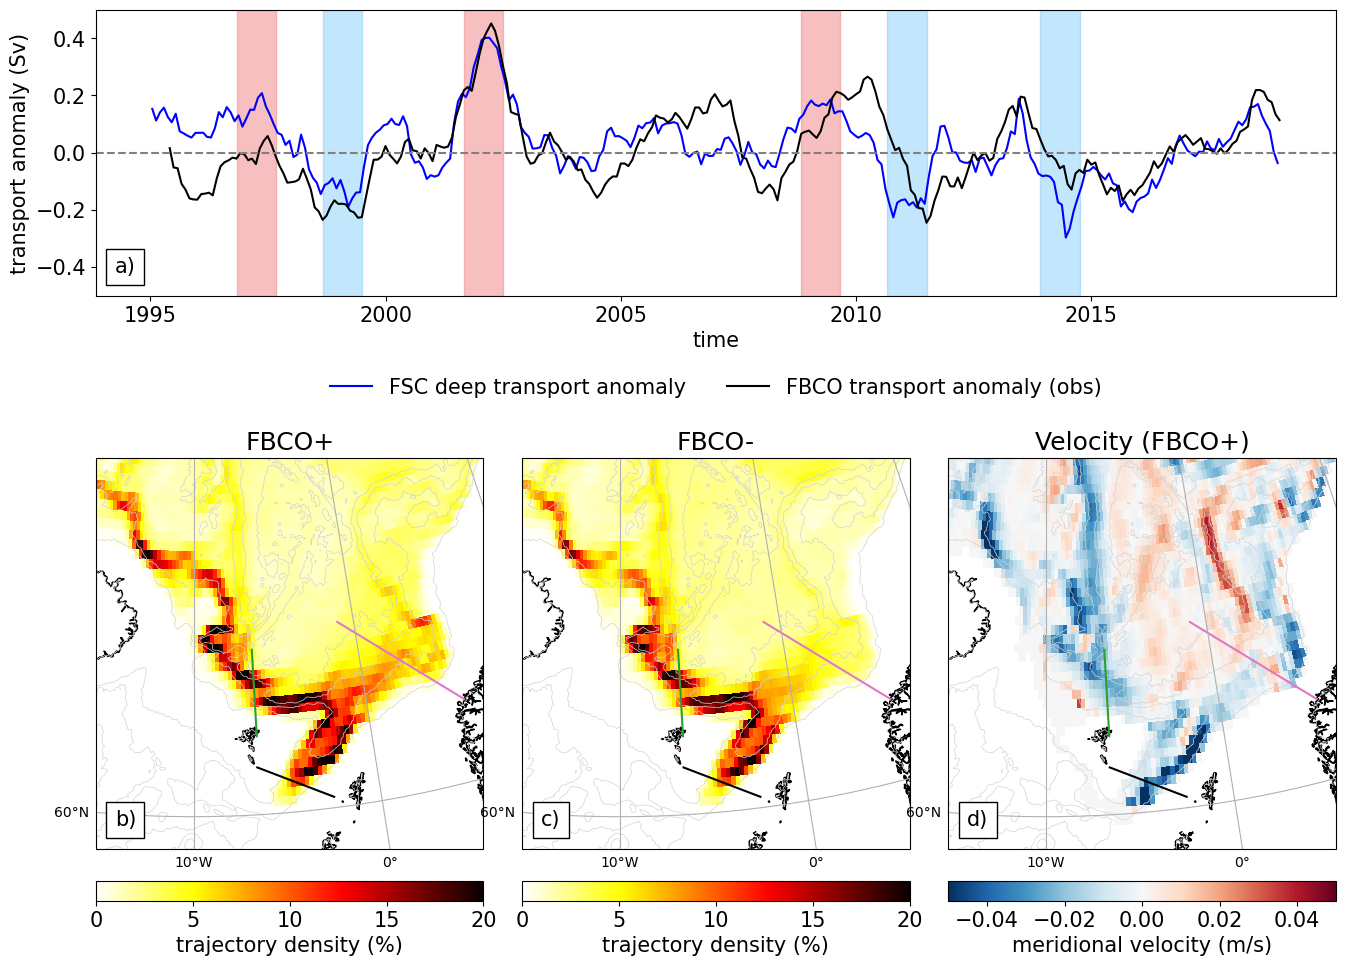

In [29]:
fig = plt.figure(figsize=(16, 13))  # Wider to accommodate 3 maps
gs = gridspec.GridSpec(
    nrows=2, ncols=3, height_ratios=[0.6, 1.5], hspace=0.0, wspace=0.1
)

# ---- TOP PANEL: TIME SERIES ----
ax1 = fig.add_subplot(gs[0, :])
S_trspt_detrend.sel(time_counter=slice("1996", "2019")).plot(
    ax=ax1, color="blue", label="FSC deep transport anomaly"
)
detrend_dim(
    FBC_obs_trspt_detrend.rolling(time_counter=12, center=True).mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019")).plot(
    ax=ax1, color="k", label="FBCO transport anomaly (obs)"
)
ax1.set_ylabel("transport anomaly (Sv)", color="k")
ax1.tick_params(axis="y", labelcolor="k")

# ax2 = ax1.twinx()
# detrend_dim(rolling_mean_NAO, dim="time_counter")[1].sel(
#     time_counter=slice("1996", "2019")
# ).plot(ax=ax2, color="k", alpha=0.4, label="NAO")
# ax2.set_ylabel("NAO (detrended)", color="dimgrey")
# ax2.tick_params(axis="y", labelcolor="dimgrey")


years = pd.date_range(start="1995", end="2020", freq="5Y")
ax1.set_xticks(years)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# ax1.set_xlim(ax1.get_xlim())

for start, end, color in [
    ("1997-11-01", "1998-09-01", "lightcoral"),
    ("2002-09-01", "2003-07-01", "lightcoral"),
    ("2009-11-01", "2010-09-01", "lightcoral"),
    ("1999-09-01", "2000-07-01", "lightskyblue"),
    ("2011-09-01", "2012-07-01", "lightskyblue"),
    ("2014-12-01", "2015-10-01", "lightskyblue"),
]:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.5)

ax1.axhline(y=0, color="grey", linestyle="dashed")
ax1.set_xlabel("time")
ax1.set_ylim(-0.5, 0.5)
# Anchored label
at = AnchoredText("a)", prop=dict(size=15), frameon=True, loc="lower left")
ax1.add_artist(at)

# Custom Legend
line_legend = [
    # Line2D([0], [0], color="k", alpha=0.4, label="NAO"),
    Line2D([0], [0], color="b", label="FSC deep transport anomaly"),
    Line2D([0], [0], color="k", label="FBCO transport anomaly (obs)"),
]

ax1.legend(
    handles=line_legend,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    frameon=False,
    ncol=3,
)

# ---- BOTTOM PANELS: THREE MAPS ----
axes = [
    fig.add_subplot(
        gs[1, i],
        projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77),
    )
    for i in range(3)
]

# map data for each subplot
map_data = [
    mean_high_transport * 10,
    mean_low_transport * 10,
    mean_vvel_high_trspt_maps * msk,
]

titles = ["FBCO+", "FBCO-", "Velocity (FBCO+)"]
labels = ["b)", "c)", "d)"]
cmaps = ["hot_r", "hot_r", "RdBu_r"]
vmins = [0, 0, -0.05]
vmaxs = [20, 20, 0.05]
cbar_labels = [
    "trajectory density (%)",
    "trajectory density (%)",
    "meridional velocity (m/s)",
]

for i, ax in enumerate(axes):
    ax.set_extent([-15, 5, 59, 69], crs=ccrs.PlateCarree())
    ax.pcolormesh(
        mesh_mask.nav_lon,
        mesh_mask.nav_lat,
        land_mask,
        transform=ccrs.PlateCarree(),
        cmap="binary",
    )

    im = ax.pcolormesh(
        lon,
        lat,
        map_data[i],
        cmap=cmaps[i],
        vmin=vmins[i],
        vmax=vmaxs[i],
        transform=ccrs.PlateCarree(),
    )

    ax.coastlines()
    ax.contour(
        mesh_mask.nav_lon,
        mesh_mask.nav_lat,
        bathymetry,
        levels=contour_levels,
        colors="lightgray",
        linewidths=0.5,
        alpha=1,
        transform=ccrs.PlateCarree(),
    )

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = FixedLocator(np.arange(-90, 91, 10))
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}

    ax.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
    ax.plot(
        [-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree()
    )
    # ax.plot([-15, -11.95], [66.25, 68.7], color='blue', transform=ccrs.PlateCarree())
    ax.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

    ax.set_title(titles[i])
    at = AnchoredText(labels[i], prop=dict(size=15), frameon=True, loc="lower left")
    ax.add_artist(at)

    pos = ax.get_position()
    cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.04, pos.width, 0.015])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label(cbar_labels[i])

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("Fig7_trspt_ts_pathways_with_velocity.png", dpi=300, bbox_inches="tight")
plt.show()

## Figure 8

In [30]:
ds = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/svinoy_expt/data_svinoy/level2/svinoy_parcels_releases_seed-2345.zarr",
    engine="zarr",
    chunks="auto",
)

ds = filter_beached_particles(ds, "obs")

ds = ds.where(ds.age * hours_to_years < 2, drop=False)

p = ds
p["start_time"] = p.isel(obs=0).time
p = p.set_coords("start_time")
p = p.set_xindex("start_time")

# Get S section and particles that only cross the S sec

S = (ds.lon < -2.5) & (ds.lat > 60.3) & (ds.lon > -6.5) & (ds.lat < 61.3)

S_box = ds.where(S, drop=False)


# Calculate slope and intercept
dist = 0.3
m_S, b_S = calculate_slope_intercept(-6.5, 61.3 - dist, -2.5, 60.3 - dist)
m_S2, b_S2 = calculate_slope_intercept(
    -6.5, 61.3 + dist, -2.5, 60.3 + dist
)  # .8 comes from max 2m/s velocity*12h = 86km convert km to degree = ~.77 degree

print("slope (m) is:", m_S)
print("y-intercept (b) is:", b_S)

ds_S_window = (
    S_box.lat >= S_box.lon * m_S + b_S
)  # if latitude above that line, set to True
ds_S_window2 = (
    S_box.lat <= S_box.lon * m_S2 + b_S2
)  # if latitude BELOW that line, set to True
ds_S_line_cross = (S_box.lat >= S_box.lon * m_S + b_S) & (
    S_box.lat <= S_box.lon * m_S2 + b_S2
)

ds_S_window = ds_S_window.astype(int)
ds_S_window2 = ds_S_window2.astype(int)
ds_S_line_cross = ds_S_line_cross.astype(int)

# ds_S_window
ds_S = ds.where(ds_S_window, drop=False)
ds_S2 = ds.where(ds_S_window2, drop=False)

ds_S_line = ds.where(ds_S_window & ds_S_window2, drop=False)

S_line_cross = filter_trajectories(ds_S, p)

slope (m) is: -0.25
y-intercept (b) is: 59.375


In [31]:
hmap_S_line = compute_probability_perc(S_line_cross["traj_line"])
lon, lat = hmap_S_line.lon.values, hmap_S_line.lat.values

In [32]:
## Svinoy sections high versus low transport

svinoy = xr.open_dataset("/gxfs_work/geomar/smomw452/GLORYS12/Data/Svinoy_section.nc")
svinoy_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        svinoy.vosaline,
        svinoy.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
svinoy_overflow = svinoy.where(svinoy_sigma0 > 28)


# high trspt
input_date_2003 = "2002-09-01", "2003-07-01"
input_date_2009 = "2009-11-01", "2010-09-01"
input_date_1997 = "1997-11-01", "1998-09-01"

# low trspt
input_date_2012 = "2011-09-01", "2012-07-01"
input_date_1999 = "1999-01-01", "1999-12-01"
input_date_2014 = "2014-12-01", "2015-10-01"


# Mean fields
vel_2003 = svinoy.u_rot_normal.sel(time_counter=slice(*input_date_2003)).mean(
    dim="time_counter"
)
sal_2003 = svinoy.vosaline.sel(time_counter=slice(*input_date_2003)).mean(
    dim="time_counter"
)
temp_2003 = svinoy.votemper.sel(time_counter=slice(*input_date_2003)).mean(
    dim="time_counter"
)
sigma_2003 = svinoy_sigma0.sel(time_counter=slice(*input_date_2003)).mean(
    dim="time_counter"
)

vel_2009 = svinoy.u_rot_normal.sel(time_counter=slice(*input_date_2009)).mean(
    dim="time_counter"
)
sal_2009 = svinoy.vosaline.sel(time_counter=slice(*input_date_2009)).mean(
    dim="time_counter"
)
temp_2009 = svinoy.votemper.sel(time_counter=slice(*input_date_2009)).mean(
    dim="time_counter"
)
sigma_2009 = svinoy_sigma0.sel(time_counter=slice(*input_date_2009)).mean(
    dim="time_counter"
)

vel_1997 = svinoy.u_rot_normal.sel(time_counter=slice(*input_date_1997)).mean(
    dim="time_counter"
)
sal_1997 = svinoy.vosaline.sel(time_counter=slice(*input_date_1997)).mean(
    dim="time_counter"
)
temp_1997 = svinoy.votemper.sel(time_counter=slice(*input_date_1997)).mean(
    dim="time_counter"
)


vel_2012 = svinoy.u_rot_normal.sel(time_counter=slice(*input_date_2012)).mean(
    dim="time_counter"
)
sal_2012 = svinoy.vosaline.sel(time_counter=slice(*input_date_2012)).mean(
    dim="time_counter"
)
temp_2012 = svinoy.votemper.sel(time_counter=slice(*input_date_2012)).mean(
    dim="time_counter"
)
sigma_2012 = svinoy_sigma0.sel(time_counter=slice(*input_date_2012)).mean(
    dim="time_counter"
)


def high_trspt(data):
    slices_high_trspt = [
        data.sel(time_counter=slice(*input_date_1997)),
        data.sel(time_counter=slice(*input_date_2003)),
        data.sel(time_counter=slice(*input_date_2009)),
    ]
    return slices_high_trspt


def low_trspt(data):
    slices_low_trspt = [
        data.sel(time_counter=slice(*input_date_2012)),
        data.sel(time_counter=slice(*input_date_1999)),
        data.sel(time_counter=slice(*input_date_2014)),
    ]
    return slices_low_trspt


high_trspt_svinoy = xr.concat(high_trspt(svinoy), dim="time_counter").mean(
    dim="time_counter"
)

high_trspt_sigma_svinoy = xr.concat(high_trspt(svinoy_sigma0), dim="time_counter").mean(
    dim="time_counter"
)

low_trspt_svinoy = xr.concat(low_trspt(svinoy), dim="time_counter").mean(
    dim="time_counter"
)
low_trspt_sigma_svinoy = xr.concat(low_trspt(svinoy_sigma0), dim="time_counter").mean(
    dim="time_counter"
)

# Difference
vel_diff = high_trspt_svinoy.u_rot_normal - low_trspt_svinoy.u_rot_normal
sal_diff = high_trspt_svinoy.vosaline - low_trspt_svinoy.vosaline
temp_diff = high_trspt_svinoy.votemper - low_trspt_svinoy.votemper

cmap_vel = plt.get_cmap("bwr")
cmap_vel.set_bad(color="gray")

cmap_sal = plt.get_cmap("PuOr_r")
cmap_sal.set_bad(color="gray")


cmap_temp = plt.get_cmap("RdBu_r")
cmap_temp.set_bad(color="gray")

In [33]:
# define the first section
EIC = (
    (ds_overflows.lon > -15)
    & (ds_overflows.lat > 66.25)
    & (ds_overflows.lon < -11.95)
    & (ds_overflows.lat < 68.7)
)

Svinoy = (
    (ds_overflows.lon < 5.5)
    & (ds_overflows.lat > 62.24)
    & (ds_overflows.lon > -1)
    & (ds_overflows.lat < 65)
)

N_section = (
    (ds_overflows.lon > -6.0833 - 5)
    & (ds_overflows.lat > 62.3333)
    & (ds_overflows.lon < -6.0833 + 5)
    & (ds_overflows.lat < 64.5)
)

Svinoy_box = ds_overflows.where(Svinoy, drop=False)
EIC_box = ds_overflows.where(EIC, drop=False)
N_box = ds_overflows.where(N_section, drop=False)


ds_Svinoy = process_section("Svinoy", ds_overflows)["ds_line"]
ds_EIC = process_section("EIC", ds_overflows)["ds_line"]  # ds_overflows
ds_N = process_section("N", ds_overflows)["ds_line"]


Svinoy_line_cross = filter_trajectories(ds_Svinoy, ds_overflows)
EIC_line_cross = filter_trajectories(ds_EIC, ds_overflows)
N_line_cross = filter_trajectories(ds_N, ds_overflows)

## cross section trajectories

Svinoy_trajectories = set(Svinoy_line_cross["traj_line"]["trajectory"].values)
EIC_trajectories = set(EIC_line_cross["traj_line"]["trajectory"].values)
N_trajectories = set(N_line_cross["traj_line"]["trajectory"].values)
overflows_trajectories = set(ds_overflows["trajectory"].values)

filtered_svinoy_trajectories = [
    traj for traj in Svinoy_trajectories if traj not in N_trajectories
]
filtered_N_trajectories = [
    traj for traj in N_trajectories if traj not in Svinoy_trajectories
]  #  and traj not in EIC_trajectories
filtered_EIC_trajectories = [
    traj for traj in EIC_trajectories if traj not in Svinoy_trajectories
]

intersecting_svinoy_only_overflows = sorted(
    set(filtered_svinoy_trajectories).intersection(overflows_trajectories)
)
intersection_N_only_overflows = sorted(
    set(filtered_N_trajectories).intersection(overflows_trajectories)
)
intersecting_N_Svinoy_overflows = sorted(
    set(Svinoy_trajectories)
    .intersection(N_trajectories)
    .intersection(overflows_trajectories)
)

overflows_crossing_only_Svinoy = ds_overflows.sel(
    trajectory=intersecting_svinoy_only_overflows
)

In [37]:
Svinoy_crossing_only_heatmap = compute_probability_perc(overflows_crossing_only_Svinoy)

In [40]:
plt.rcParams.update({"font.size": 14})

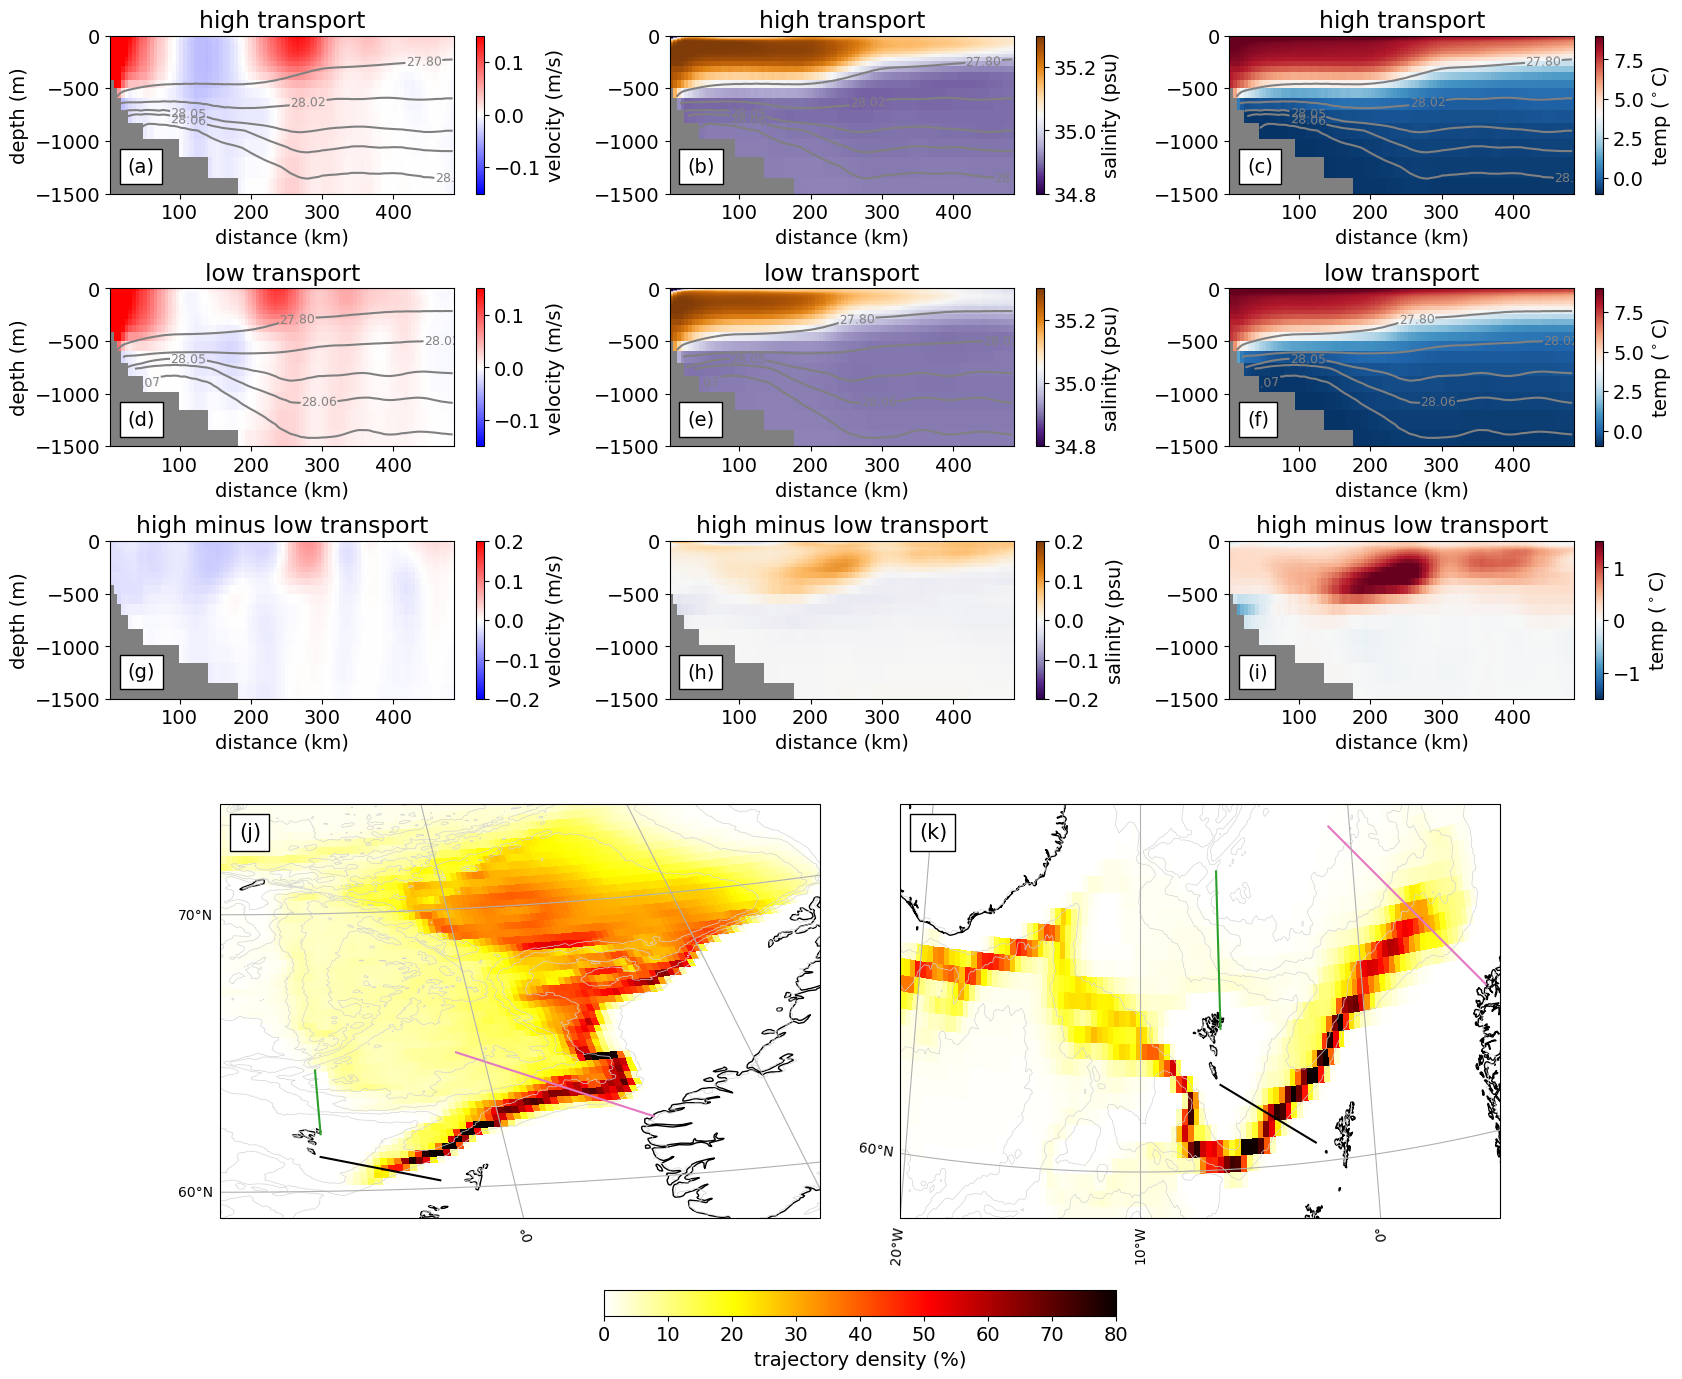

In [34]:
# === Figure layout ===
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 3, height_ratios=[3, 3, 3, 9], hspace=0.4, wspace=0.3)

# Panel labels
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)", "(k)"]
label_idx = 0

# === 3x3 hydrography section plots ===
for row, (vel, sal, temp, sigma, label, diff_flag) in enumerate(
    [
        (
            high_trspt_svinoy.u_rot_normal,
            high_trspt_svinoy.vosaline,
            high_trspt_svinoy.votemper,
            high_trspt_sigma_svinoy,
            "high transport",
            False,
        ),
        (
            low_trspt_svinoy.u_rot_normal,
            low_trspt_svinoy.vosaline,
            low_trspt_svinoy.votemper,
            low_trspt_sigma_svinoy,
            "low transport",
            False,
        ),
        (vel_diff, sal_diff, temp_diff, None, "high minus low transport", True),
    ]
):
    for col, (data, cmap, vmin, vmax, varname) in enumerate(
        [
            (
                vel,
                cmap_vel,
                -0.2 if diff_flag else -0.15,
                0.2 if diff_flag else 0.15,
                "velocity (m/s)",
            ),
            (
                sal,
                cmap_sal,
                -0.2 if diff_flag else 34.8,
                0.2 if diff_flag else 35.3,
                "salinity (psu)",
            ),
            (
                temp,
                cmap_temp,
                -1.5 if diff_flag else -1,
                1.5 if diff_flag else 9,
                r"temp ($^\circ$C)",
            ),
        ]
    ):
        ax = fig.add_subplot(gs[row, col])
        pc = ax.pcolormesh(
            svinoy.c / 1e3, -svinoy.z, data, cmap=cmap, vmin=vmin, vmax=vmax
        )

        if not diff_flag and sigma is not None:
            CS = ax.contour(
                svinoy.c / 1e3,
                -svinoy.z,
                sigma,
                [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
                colors="gray",
            )
            ax.clabel(CS, inline=True, fontsize=9)

        ax.set_xlabel("distance (km)")
        if col == 0:
            ax.set_ylabel("depth (m)")
        ax.set_ylim(-1500, 0)
        ax.set_title(label)
        fig.colorbar(pc, ax=ax).set_label(varname)

        at = AnchoredText(
            labels[label_idx], loc="lower left", prop=dict(size=14), frameon=True
        )
        ax.add_artist(at)
        label_idx += 1


ax_i = fig.add_axes(
    [0.18, 0.08, 0.3, 0.32],
    projection=ccrs.LambertConformal(central_longitude=-10, central_latitude=70),
)
ax_j = fig.add_axes(
    [0.52, 0.08, 0.3, 0.32],
    projection=ccrs.LambertConformal(central_longitude=-10, central_latitude=70),
)


ax_i.set_extent([-10, 10, 59, 73], crs=ccrs.PlateCarree())
m1 = ax_i.pcolormesh(
    Svinoy_crossing_only_heatmap.lon,
    Svinoy_crossing_only_heatmap.lat,
    Svinoy_crossing_only_heatmap,
    cmap="hot_r",
    vmin=0,
    vmax=80,
    transform=ccrs.PlateCarree(),
)
ax_i.coastlines()
ax_i.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)

gl = ax_i.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}


ax_i.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
ax_i.plot(
    [-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree()
)
ax_i.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

at_i = AnchoredText(
    labels[label_idx], loc="upper left", prop=dict(size=15), frameon=True
)
ax_i.add_artist(at_i)
label_idx += 1


ax_j.set_extent([-20, 5, 59, 65], crs=ccrs.PlateCarree())
ax_j.pcolormesh(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    land_mask,
    transform=ccrs.PlateCarree(),
    cmap="binary",
)
x = ax_j.pcolormesh(
    lon, lat, hmap_S_line, cmap="hot_r", vmin=0, vmax=80, transform=ccrs.PlateCarree()
)

ax_j.coastlines()
ax_j.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)

gl = ax_j.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}


ax_j.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
ax_j.plot(
    [-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree()
)
ax_j.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())


at_j = AnchoredText(
    labels[label_idx], loc="upper left", prop=dict(size=15), frameon=True
)
ax_j.add_artist(at_j)
label_idx += 1


cbar = fig.colorbar(
    x, ax=[ax_i, ax_j], orientation="horizontal", pad=0.14, fraction=0.05
)
cbar.set_label("trajectory density (%)")


for ax in [ax_i, ax_j]:
    ax.set_aspect("auto")


plt.tight_layout()
# plt.savefig('Fig8_svinoy_sec_hydrography_with_map.png', dpi=300, bbox_inches='tight')
plt.show()

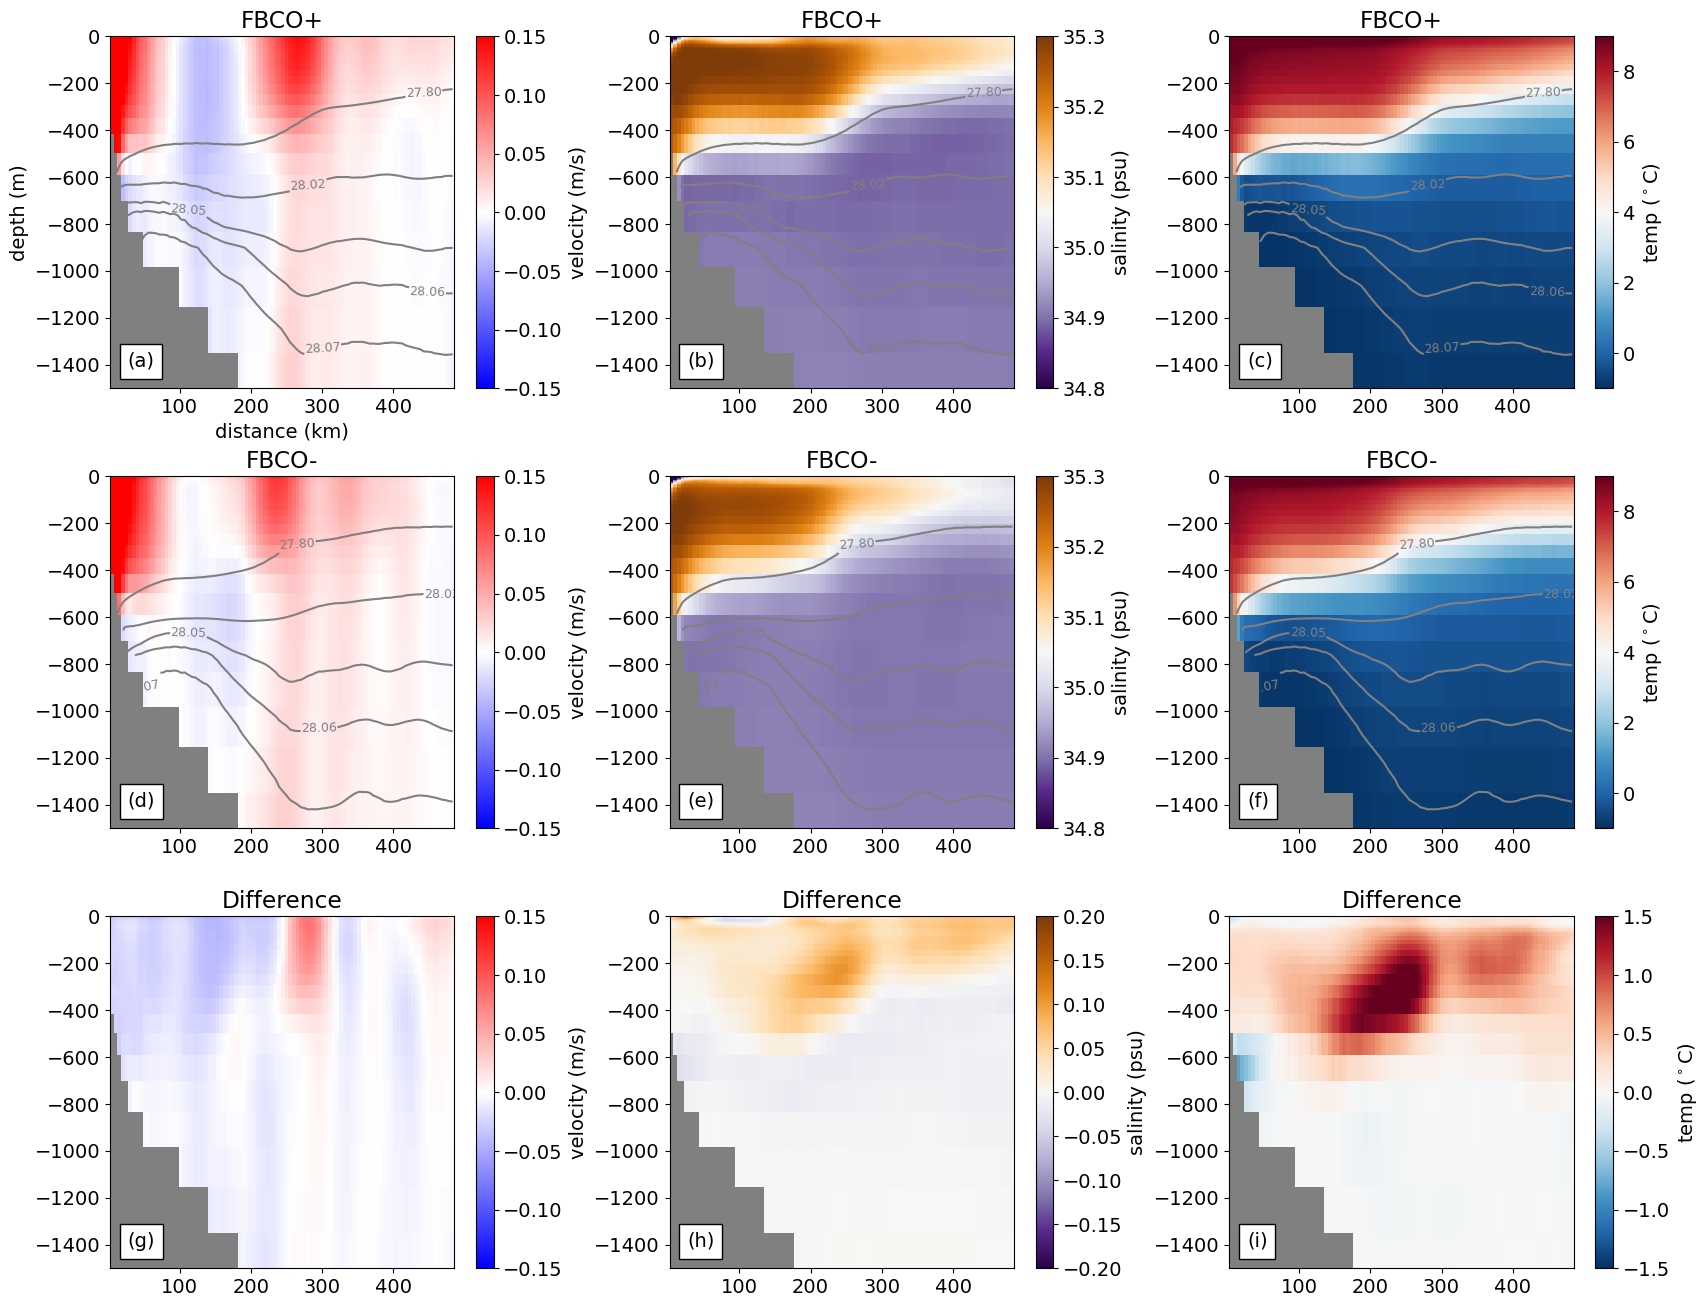

In [ ]:
# === Figure layout ===
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 3, hspace=0.25, wspace=0.3)  # 3x3 grid

# Panel labels
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
label_idx = 0

# === 3x3 hydrography section plots ===
for row, (vel, sal, temp, sigma, label, diff_flag) in enumerate(
    [
        (
            high_trspt_svinoy.u_rot_normal,
            high_trspt_svinoy.vosaline,
            high_trspt_svinoy.votemper,
            high_trspt_sigma_svinoy,
            "FBCO+",
            False,
        ),
        (
            low_trspt_svinoy.u_rot_normal,
            low_trspt_svinoy.vosaline,
            low_trspt_svinoy.votemper,
            low_trspt_sigma_svinoy,
            "FBCO-",
            False,
        ),
        (
            vel_diff,
            sal_diff,
            temp_diff,
            None,
            "Difference",
            True,
        ),
    ]
):
    for col, (data, cmap, vmin, vmax, varname) in enumerate(
        [
            (
                vel,
                cmap_vel,
                -0.15 if diff_flag else -0.15,
                0.15 if diff_flag else 0.15,
                "velocity (m/s)",
            ),
            (
                sal,
                cmap_sal,
                -0.2 if diff_flag else 34.8,
                0.2 if diff_flag else 35.3,
                "salinity (psu)",
            ),
            (
                temp,
                cmap_temp,
                -1.5 if diff_flag else -1,
                1.5 if diff_flag else 9,
                r"temp ($^\circ$C)",
            ),
        ]
    ):
        ax = fig.add_subplot(gs[row, col])
        pc = ax.pcolormesh(
            svinoy.c / 1e3, -svinoy.z, data, cmap=cmap, vmin=vmin, vmax=vmax
        )

        # Only add sigma contours for non-difference plots
        if not diff_flag and sigma is not None:
            CS = ax.contour(
                svinoy.c / 1e3,
                -svinoy.z,
                sigma,
                [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
                colors="gray",
            )
            ax.clabel(CS, inline=True, fontsize=9)

        # ax.set_xlabel("distance (km)")
        # if col == 0:
        #     ax.set_ylabel("depth (m)")

        if label_idx == 0:
            ax.set_xlabel("distance (km)")
            ax.set_ylabel("depth (m)")
        else:
            ax.xaxis.set_label_text("")
            ax.yaxis.set_label_text("")

        ax.set_ylim(-1500, 0)
        ax.set_title(label)
        fig.colorbar(pc, ax=ax).set_label(varname)

        # Add panel letter
        at = AnchoredText(
            labels[label_idx], loc="lower left", prop=dict(size=14), frameon=True
        )
        ax.add_artist(at)
        label_idx += 1

plt.tight_layout()
# plt.savefig('Fig8_svinoy_sec_hydrography.png', dpi=300, bbox_inches='tight')
plt.show()

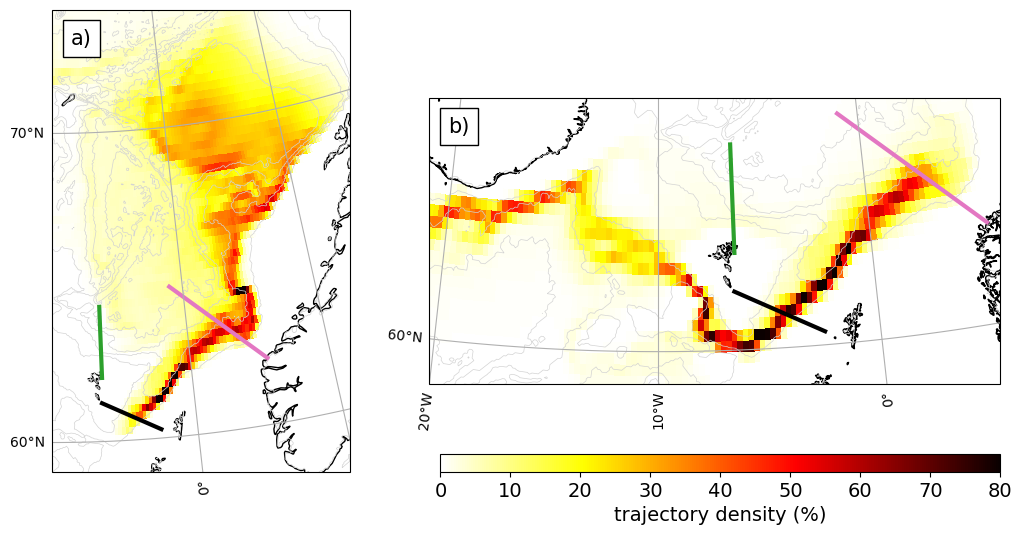

In [ ]:
# Define the projection
proj = ccrs.LambertConformal(central_longitude=-10, central_latitude=70)

# Create figure with 2 maps side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": proj})

labels = ["a)", "b)"]
label_idx = 0

# ----------------- Left map -----------------
ax1.set_extent([-10, 10, 59, 73], crs=ccrs.PlateCarree())
m1 = ax1.pcolormesh(
    Svinoy_crossing_only_heatmap.lon,
    Svinoy_crossing_only_heatmap.lat,
    Svinoy_crossing_only_heatmap,
    cmap="hot_r",
    vmin=0,
    vmax=80,
    transform=ccrs.PlateCarree(),
)

ax1.coastlines()
ax1.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

ax1.plot(
    [5.5, -1],
    [62.24, 65.0],
    color="tab:pink",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)
ax1.plot(
    [-6.43, -6.43],
    [62.15, 64.5],
    color="tab:green",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)
ax1.plot(
    [-6.5, -2.5], [61.3, 60.3], color="k", linewidth=3, transform=ccrs.PlateCarree()
)

at1 = AnchoredText(
    labels[label_idx], loc="upper left", prop=dict(size=15), frameon=True
)
ax1.add_artist(at1)
label_idx += 1

# ----------------- Right map -----------------
ax2.set_extent([-20, 5, 59, 65], crs=ccrs.PlateCarree())
ax2.pcolormesh(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    land_mask,
    cmap="binary",
    transform=ccrs.PlateCarree(),
)
m2 = ax2.pcolormesh(
    lon, lat, hmap_S_line, cmap="hot_r", vmin=0, vmax=80, transform=ccrs.PlateCarree()
)

ax2.coastlines()
ax2.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)

gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

ax2.plot(
    [5.5, -1],
    [62.24, 65.0],
    color="tab:pink",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)
ax2.plot(
    [-6.43, -6.43],
    [62.15, 64.5],
    color="tab:green",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)
ax2.plot(
    [-6.5, -2.5], [61.3, 60.3], color="k", linewidth=3, transform=ccrs.PlateCarree()
)

at2 = AnchoredText(
    labels[label_idx], loc="upper left", prop=dict(size=15), frameon=True
)
ax2.add_artist(at2)

# Create a custom axes for the colorbar: [left, bottom, width, height] in figure coordinates
cbax = fig.add_axes([0.5, 0.11, 0.4, 0.03])

# Create the colorbar in that axes
cbar = fig.colorbar(m1, cax=cbax, orientation="horizontal")
cbar.set_label("trajectory density (%)")


# Reduce horizontal space between maps
plt.subplots_adjust(wspace=-0.1)
# plt.savefig('Fig8a_svinoy_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 9

In [37]:
svinoy_annual_mean = svinoy.groupby("time_counter.year").mean(dim="time_counter")
svinoy_southward_only = svinoy.where(svinoy.u_rot_normal < 0).sel(c=slice(0, 150e3))
svinoy_southward_overflow = svinoy_southward_only.where(svinoy_sigma0 > 28)


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return fit, da - fit


svinoy_trspt = bl.calculate_transport(
    svinoy_southward_only.sel(z=slice(500, None))
).trsp

S_trspt = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/S_trspt_1.nc"
).S_trspt
S_trspt_seasonlity_remove = S_trspt.groupby("time_counter.month") - S_trspt.groupby(
    "time_counter.month"
).mean(dim="time_counter")
S_trspt_seasonlity_remove_detrend = detrend_dim(
    S_trspt_seasonlity_remove, "time_counter"
)[1]
S_trspt_detrend = detrend_dim(
    S_trspt_seasonlity_remove.rolling(time_counter=12, center=True).mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019"))


def remove_seasonality(data):
    return data.groupby("time_counter.month") - data.groupby("time_counter.month").mean(
        dim="time_counter"
    )

In [38]:
plt.rcParams.update({"font.size": 13})

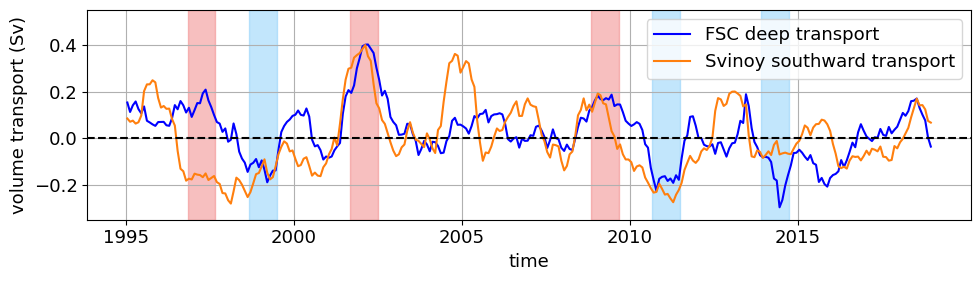

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 3))

(S_trspt_detrend).plot(ax=ax1, color="blue", label="FSC deep transport")
(
    -detrend_dim(
        bl.calculate_transport(svinoy_southward_only.sel(z=slice(500, None)))
        .trsp.rolling(time_counter=12, center=True)
        .mean()
        .sel(time_counter=slice("1996", "2019")),
        "time_counter",
    )[1]
).plot(ax=ax1, color="tab:orange", label="Svinoy southward transport")

ax1.set_ylabel("volume transport (Sv)", color="k")
ax1.tick_params(axis="y", labelcolor="k")


# high transport
ax1.axvspan(
    pd.to_datetime("2002-09-01"),
    pd.to_datetime("2003-07-01"),
    color="lightcoral",
    alpha=0.5,
)
ax1.axvspan(
    pd.to_datetime("2009-11-01"),
    pd.to_datetime("2010-09-01"),
    color="lightcoral",
    alpha=0.5,
)
ax1.axvspan(
    pd.to_datetime("1997-11-01"),
    pd.to_datetime("1998-09-01"),
    color="lightcoral",
    alpha=0.5,
)

# low transport
ax1.axvspan(
    pd.to_datetime("2011-09-01"),
    pd.to_datetime("2012-07-01"),
    color="lightskyblue",
    alpha=0.5,
)
ax1.axvspan(
    pd.to_datetime("1999-09-01"),
    pd.to_datetime("2000-07-01"),
    color="lightskyblue",
    alpha=0.5,
)
ax1.axvspan(
    pd.to_datetime("2014-12-01"),
    pd.to_datetime("2015-10-01"),
    color="lightskyblue",
    alpha=0.5,
)

# ax1.legend(loc=(1.02,.62))
ax1.legend(loc="upper right")
years = pd.date_range(start="1995-01-01", end="2020-01-01", freq="5Y")
ax1.set_xlabel("time")
ax1.set_xticks(years)
# plt.title('FSC and Svinoy Transport')
ax1.set_ylim(-0.35, 0.55)
plt.axhline(y=0, linestyle="dashed", color="k")
plt.grid()
plt.tight_layout()
# plt.savefig('Fig9_FSC_Svinoy_transport_timeseries.png', dpi=300,bbox_inches='tight')

plt.show()